# Train ResNet50 Model on MIT Indoor Scene Recognition
- Input size (256 x 256 x 3)

In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import tqdm
from collections import namedtuple

In [2]:
print(torch.cuda.is_available())

True


## Dataset
- There are 67 Indoor categories with a total of 15620 images. The number of images varies across categories, but there are at least 100 images per category. All images are in jpg format. 

In [3]:
!ls ../../../../data/indoorCVPR_09/Images

airport_inside	computerroom	     inside_subway   pantry
artstudio	concert_hall	     jewelleryshop   poolinside
auditorium	corridor	     kindergarden    prisoncell
bakery		deli		     kitchen	     restaurant
bar		dentaloffice	     laboratorywet   restaurant_kitchen
bathroom	dining_room	     laundromat      shoeshop
bedroom		elevator	     library	     stairscase
bookstore	fastfood_restaurant  livingroom      studiomusic
bowling		florist		     lobby	     subway
buffet		gameroom	     locker_room     toystore
casino		garage		     mall	     trainstation
children_room	greenhouse	     meeting_room    tv_studio
church_inside	grocerystore	     movietheater    videostore
classroom	gym		     museum	     waitingroom
cloister	hairsalon	     nursery	     warehouse
closet		hospitalroom	     office	     winecellar
clothingstore	inside_bus	     operating_room


In [4]:
data_dir = '../../../../data/indoorCVPR_09/Images'
classes = os.listdir(data_dir)
print(f"There are {len(classes)} classes: \n {classes}")

There are 67 classes: 
 ['grocerystore', 'videostore', 'livingroom', 'office', 'toystore', 'gameroom', 'clothingstore', 'bookstore', 'dining_room', 'prisoncell', 'nursery', 'stairscase', 'tv_studio', 'deli', 'laundromat', 'elevator', 'florist', 'museum', 'cloister', 'bakery', 'bowling', 'pantry', 'bedroom', 'children_room', 'casino', 'auditorium', 'dentaloffice', 'kindergarden', 'movietheater', 'garage', 'waitingroom', 'meeting_room', 'computerroom', 'winecellar', 'bar', 'shoeshop', 'airport_inside', 'hairsalon', 'lobby', 'closet', 'subway', 'warehouse', 'corridor', 'gym', 'kitchen', 'buffet', 'library', 'jewelleryshop', 'poolinside', 'laboratorywet', 'classroom', 'hospitalroom', 'artstudio', 'greenhouse', 'studiomusic', 'concert_hall', 'restaurant_kitchen', 'operating_room', 'locker_room', 'fastfood_restaurant', 'inside_subway', 'bathroom', 'inside_bus', 'mall', 'church_inside', 'restaurant', 'trainstation']


# Data Transformations

In [5]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [6]:
# Helper function to see the image and labels
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: airport_inside (Class No: 0)


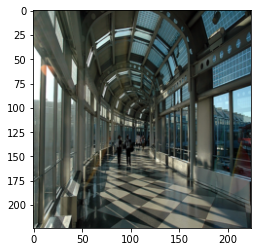

In [7]:
img, label = dataset[50]
show_sample(img, label)

# Load and Split Dataset

In [8]:
random_seed = 42
torch.manual_seed(random_seed)

In [9]:
len(dataset)

15620

In [10]:
train_set, val_set = random_split(dataset, [14000, 1620])
len(train_set), len(val_set)

(14000, 1620)

In [11]:
from torch.utils.data.dataloader import DataLoader
batch_size = 25

In [12]:
# Create training and validating dataloaders with DataLoader
train_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_set, batch_size, num_workers = 4, pin_memory=True)

In [13]:
# Visualize batches
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        print(f"Shape of images: {images.shape}")
        print(f"Shape of labels: {labels.shape}")
        print(f"labels {labels}")
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

Shape of images: torch.Size([25, 3, 224, 224])
Shape of labels: torch.Size([25])
labels tensor([41, 10, 34,  8, 60, 31, 35, 64, 55, 41, 60, 10, 14, 29,  2, 41, 40, 37,
         6, 53,  6, 37, 34, 38, 54])


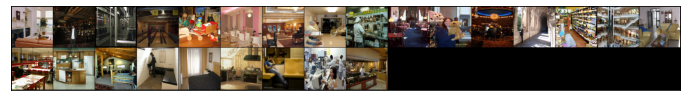

In [14]:
show_batch(train_dl)

Shape of images: torch.Size([25, 3, 224, 224])
Shape of labels: torch.Size([25])
labels tensor([59, 17, 51, 14, 54,  0, 38, 48, 19, 10,  6, 59, 51, 25, 29, 22, 26, 19,
        61, 60,  6, 65, 41, 63, 20])


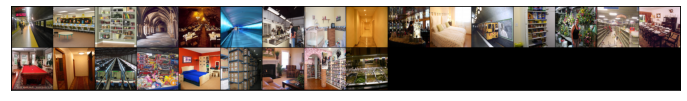

In [15]:
show_batch(val_dl)

In [16]:
next(iter(train_set))[0].shape

torch.Size([3, 224, 224])

# ResNet50 Model

In [17]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
        
        block, n_blocks, channels = config
        self.in_channels = channels[0]
        
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride=2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride=2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=self.in_channels, out_features=output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride=1):
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x

In [18]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [19]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

In [20]:
resnet50 = ResNet(resnet50_config, len(classes))
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
def evaluate_accuracy(data_iter, net, device=None):
    # If device is not specified, use net device
    if device is None and isinstance(net, torch.nn.Module):
        device = list(net.parameters())[0].device
    
    # Initialize accuracy
    acc_sum, n = 0.0, 0
    
    # For evaluation, no need to update gradient
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                # Evaluation mode, turn off dropout
                net.eval()  
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                
                # Change back to training mode
                net.train() 
            else:
                if ('is_training' in net.__code__.co_varnames):  # If there is a parameter of is_training
                    
                    # Set is_training to False
                    acc_sum += (net(X, is_training=False)[1].argmax(dim=1) == y).float().sum().item()
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
    return acc_sum / n

In [22]:
def train(train_iter, test_iter, net, optimizer, device, num_epochs):
    # Deploy the network on the gpu device
    net = net.to(device)
    print("training on", device)
    
    # Cross entropy
    loss = torch.nn.CrossEntropyLoss()
    batch_count = 0
#     collaps = 0
    
#     simplex = torch.zeros(len(train_iter.dataset), len(dataset.classes)).to(device)
    
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for  X, y in train_iter:
            
            # Input attributes
            X = X.to(device)
            
            # Tags
            y = y.to(device)
            
            # Prediction
            y_hat = net(X)
            
#             print(y_hat[0].shape)
#             print(y_hat[0])
#             print(y)
#             print('-------')
            
            # Calculate loss
            l = loss(y_hat, y)
            
            # Gradient descent
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
            
        # Test set accuracy
        test_acc = evaluate_accuracy(test_iter, net)
        
        print(f"epoch: {epoch + 1}, loss: {train_l_sum / batch_count}, train acc: {train_acc_sum / n}, test acc: {test_acc}, collaps: {time.time() - start}")

In [23]:
# lr = 0.003
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)
optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

# optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)
train(train_dl, val_dl, resnet50, optimizer, device, num_epochs)

training on cuda
epoch: 1, loss: 3.8737297517912728, train acc: 0.08342857142857144, test acc: 0.09567901234567901, collaps: 40.61176347732544
epoch: 2, loss: 1.7189765734331948, train acc: 0.14035714285714285, test acc: 0.1308641975308642, collaps: 39.96551704406738
epoch: 3, loss: 1.0657802964959826, train acc: 0.18185714285714286, test acc: 0.20617283950617285, collaps: 39.56098461151123
epoch: 4, loss: 0.7402435824275017, train acc: 0.2305, test acc: 0.19814814814814816, collaps: 39.851195335388184
epoch: 5, loss: 0.5497246667316982, train acc: 0.27221428571428574, test acc: 0.3074074074074074, collaps: 39.65148687362671
epoch: 6, loss: 0.4188063042504447, train acc: 0.32721428571428574, test acc: 0.25679012345679014, collaps: 40.238317251205444
epoch: 7, loss: 0.3275139266434981, train acc: 0.3787142857142857, test acc: 0.31851851851851853, collaps: 40.087555170059204
epoch: 8, loss: 0.25891488082706926, train acc: 0.42992857142857144, test acc: 0.3697530864197531, collaps: 42.420

# Save Model

In [38]:
!ls ../../../../

data  data.zip	deepdream_college  trained_models


In [39]:
path_save = "../../../../trained_models/resnet_50_epoch_100_train_99_test_45.h5"

In [40]:
torch.save(resnet50.state_dict(), path_save)

# Load and Evaluate Trained Model

In [41]:
new_resnet_50 = ResNet(resnet50_config, len(classes)).to(device)
new_resnet_50.load_state_dict(torch.load(path_save))

<All keys matched successfully>

In [42]:
new_resnet_50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
test_acc = evaluate_accuracy(val_dl, new_resnet_50)

In [44]:
print(f"The test acccuracy of ResNet50 is: {test_acc}")

The test acccuracy of ResNet50 is: 0.458641975308642


# Visualize Prediction

In [45]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0).to(device)
    
    # Get predictions from model
    yb = model(xb)
    
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: subway , Predicted: bookstore


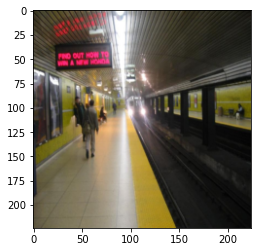

In [46]:
img, label = val_set[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, new_resnet_50))